# Air Quality (UCI) — EDA

## Load data

In [309]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

data_path = Path("../data/AirQualityUCI.csv")

# Robust read: UCI often uses ';' as separator and ',' as decimal; trailing Unnamed column may exist
df_raw = pd.read_csv(
    data_path,
    sep=';',
    decimal=',',
    header=0,
    engine='python'
)
df_raw = df_raw.loc[:, ~df_raw.columns.str.contains(r'^Unnamed')].copy()

print("Columns:", list(df_raw.columns))
print("Shape (raw):", df_raw.shape)
display(df_raw.head(3))

df = df_raw.replace(-200, np.nan).copy()

Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Shape (raw): (9471, 15)


Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502

## Data Exploration (Summary Statistics)

In [310]:
# 1. Select only numeric columns (exclude Date, Time, etc.)
numeric_df = df.select_dtypes(include=[np.number])

# 2. Compute summary statistics
mean_values = numeric_df.mean()
median_values = numeric_df.median()
variance_values = numeric_df.var()
std_values = numeric_df.std()

# 3. Combine into one clean summary table
summary_stats = pd.DataFrame({
    'Mean': mean_values,
    'Median': median_values,
    'Variance': variance_values,
    'Std Dev': std_values
})

# 4. Display the summary table
print("Summary Statistics (Mean, Median, Variance, Standard Deviation):")
display(summary_stats)

Summary Statistics (Mean, Median, Variance, Standard Deviation):


Mean     Median       Variance     Std Dev
CO(GT)            2.152750     1.8000       2.111941    1.453252
PT08.S1(CO)    1099.833166  1063.0000   47123.742575  217.080037
NMHC(GT)        218.811816   150.0000   41803.859400  204.459921
C6H6(GT)         10.083105     8.2000      55.499814    7.449820
PT08.S2(NMHC)   939.153376   909.0000   71199.011290  266.831429
NOx(GT)         246.896735   180.0000   45360.126046  212.979168
PT08.S3(NOx)    835.493605   806.0000   65955.135860  256.817320
NO2(GT)         113.091251   109.0000    2339.667327   48.370108
PT08.S4(NO2)   1456.264598  1463.0000  119859.143884  346.206794
PT08.S5(O3)    1022.906128   963.0000  158789.727561  398.484288
T                18.317829    17.8000      78.006268    8.832116
RH               49.234201    49.6000     299.874765   17.316892
AH                1.025530     0.9954       0.163065    0.403813

## Time plots

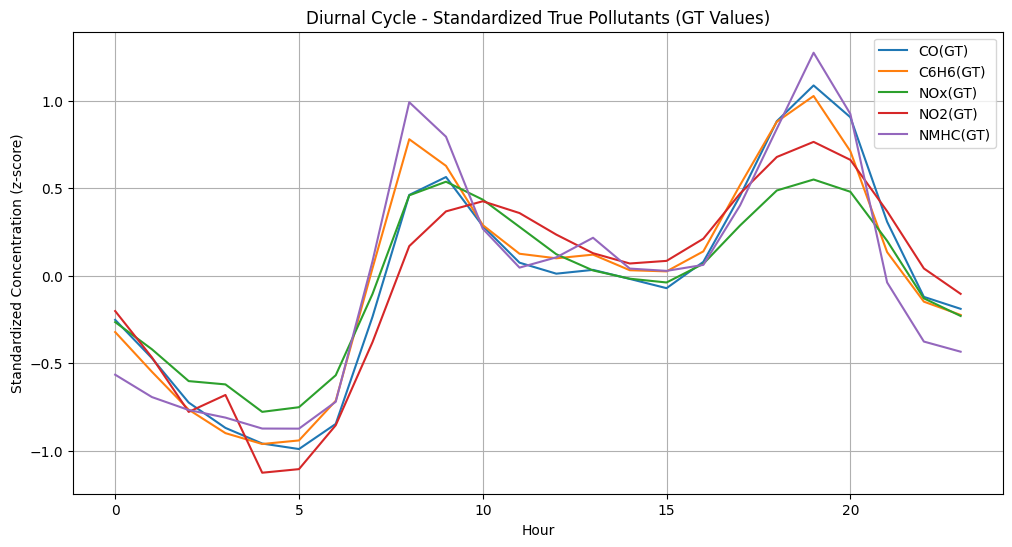

In [311]:
from math import sqrt

# 1. Create Datetime index
df['Datetime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    format='%d/%m/%Y %H.%M.%S',
    errors='coerce'
)
df = df.set_index('Datetime').sort_index()

# 2. Select pollutant columns to be put on a common scale (GT values)
pollutants_gt = [
    'CO(GT)',
    'C6H6(GT)',
    'NOx(GT)',
    'NO2(GT)',
    'NMHC(GT)'
]
pollutants_gt = [c for c in pollutants_gt if c in df.columns]

# 3. Manually perform z-score standardisation 
df_scaled = df.copy()
for col in pollutants_gt:
    mean = df_scaled[col].mean(skipna=True)
    std  = df_scaled[col].std(skipna=True)
    df_scaled[col] = (df_scaled[col] - mean) / std

# 4. Plot the diurnal cycle using standardised values
df_scaled['Hour'] = df_scaled.index.hour

plt.figure(figsize=(12, 6))
for col in pollutants_gt:
    hourly_mean = df_scaled.groupby('Hour')[col].mean()
    plt.plot(hourly_mean, label=col)

plt.title("Diurnal Cycle - Standardized True Pollutants (GT Values)")
plt.xlabel("Hour")
plt.ylabel("Standardized Concentration (z-score)")
plt.grid(True)
plt.legend()
plt.show()



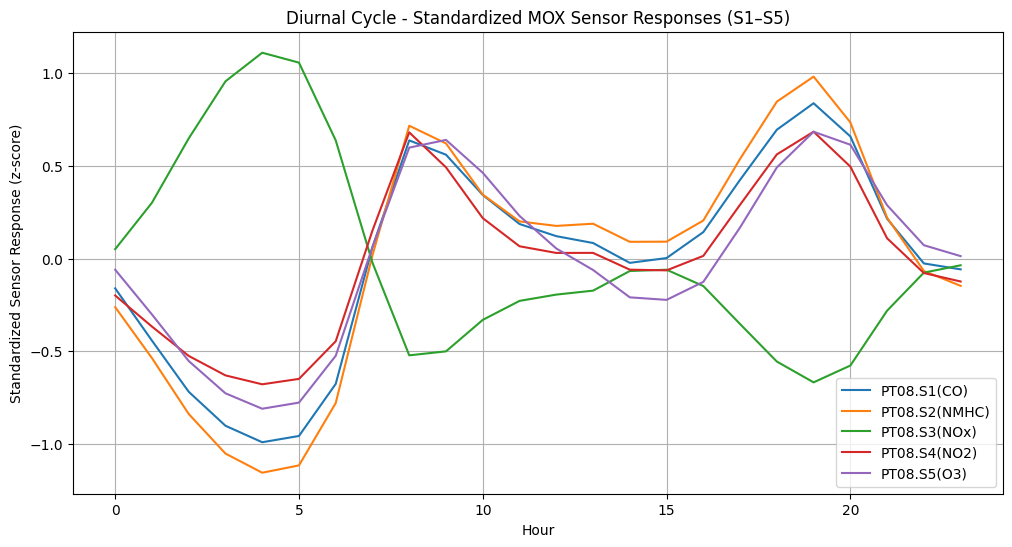

In [312]:
# select sensors
sensors = [
    'PT08.S1(CO)',
    'PT08.S2(NMHC)',
    'PT08.S3(NOx)',
    'PT08.S4(NO2)',
    'PT08.S5(O3)'
]

# standardise
df_sens_scaled = df.copy()

for col in sensors:
    mean = df_sens_scaled[col].mean(skipna=True)
    std  = df_sens_scaled[col].std(skipna=True)
    df_sens_scaled[col] = (df_sens_scaled[col] - mean) / std

# Plot the diurnal cycle of standardized S1–S5
df_sens_scaled['Hour'] = df_sens_scaled.index.hour

plt.figure(figsize=(12, 6))

for col in sensors:
    hourly_mean = df_sens_scaled.groupby('Hour')[col].mean()
    plt.plot(hourly_mean, label=col)

plt.title("Diurnal Cycle - Standardized MOX Sensor Responses (S1–S5)")
plt.xlabel("Hour")
plt.ylabel("Standardized Sensor Response (z-score)")
plt.grid(True)
plt.legend()
plt.show()



## Seasonal Plots

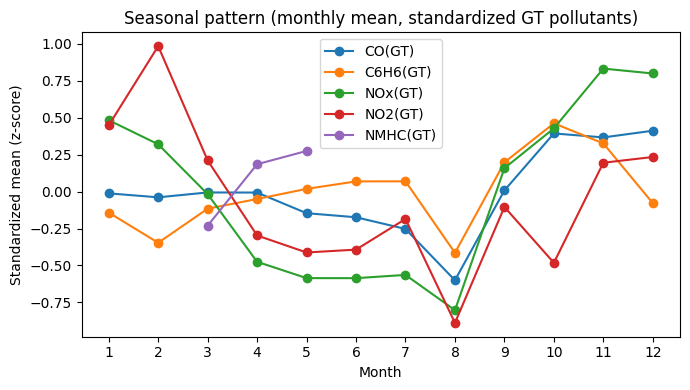

In [313]:
# Extract the "month" information from the Datetime index
df_scaled['Month'] = df_scaled.index.month

# Compute monthly averages of the standardised true pollutant variables
month_mean_scaled = df_scaled.groupby('Month')[pollutants_gt].mean()

plt.figure(figsize=(7, 4))
for col in pollutants_gt:
    plt.plot(month_mean_scaled.index, month_mean_scaled[col],
             marker='o', label=col)

plt.xlabel("Month")
plt.ylabel("Standardized mean (z-score)")
plt.title("Seasonal pattern (monthly mean, standardized GT pollutants)")
plt.xticks(range(1, 13))
plt.legend()
plt.tight_layout()
plt.show()


## Lag Plots

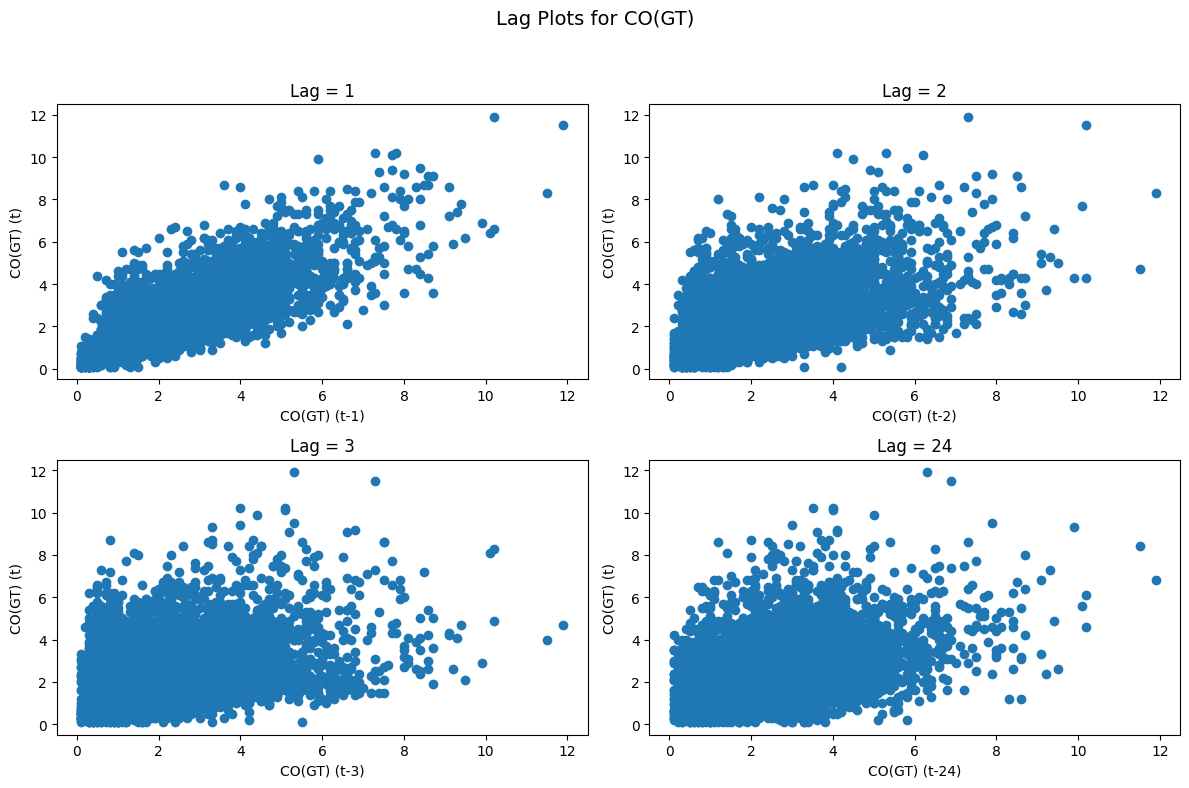

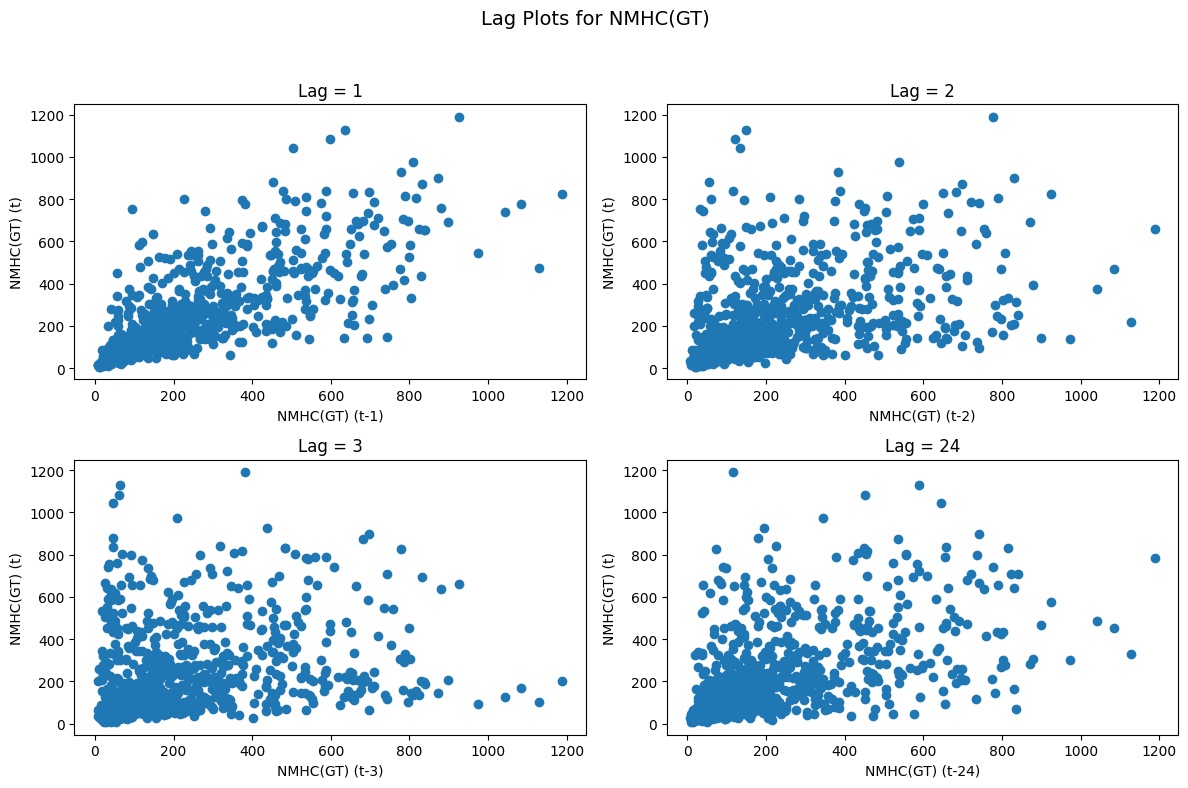

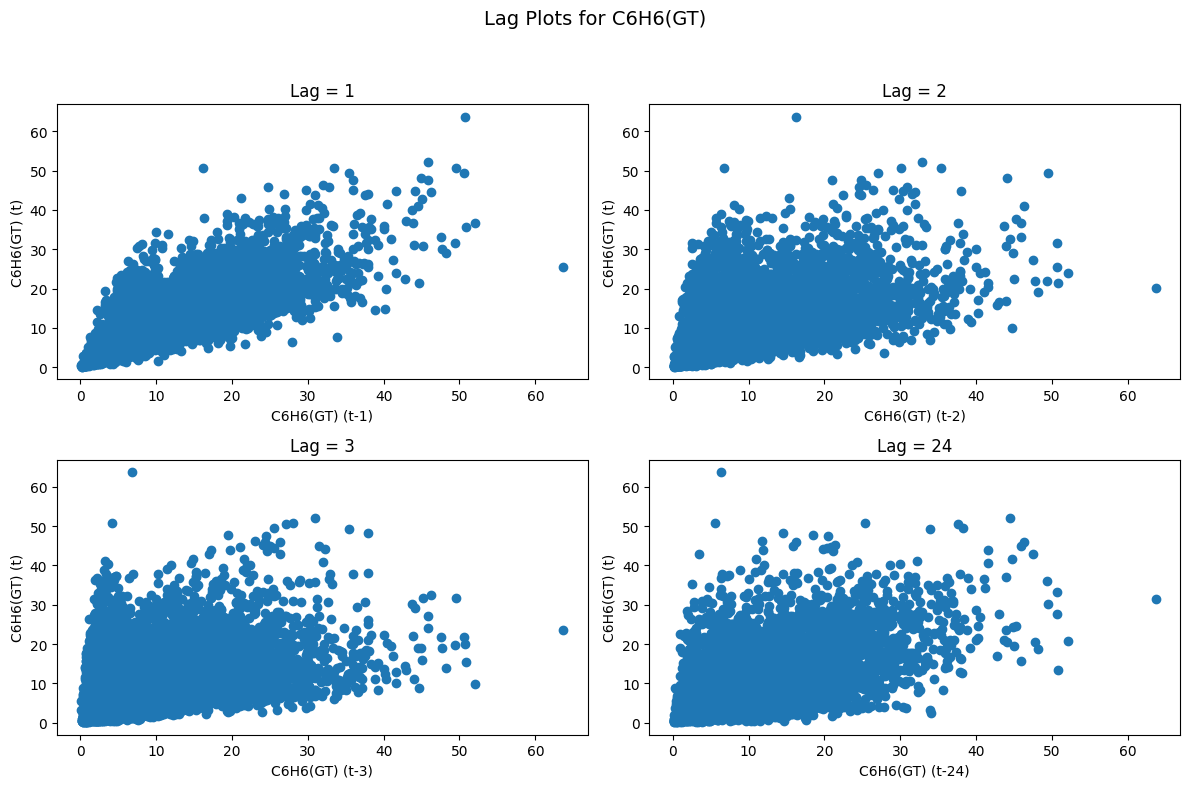

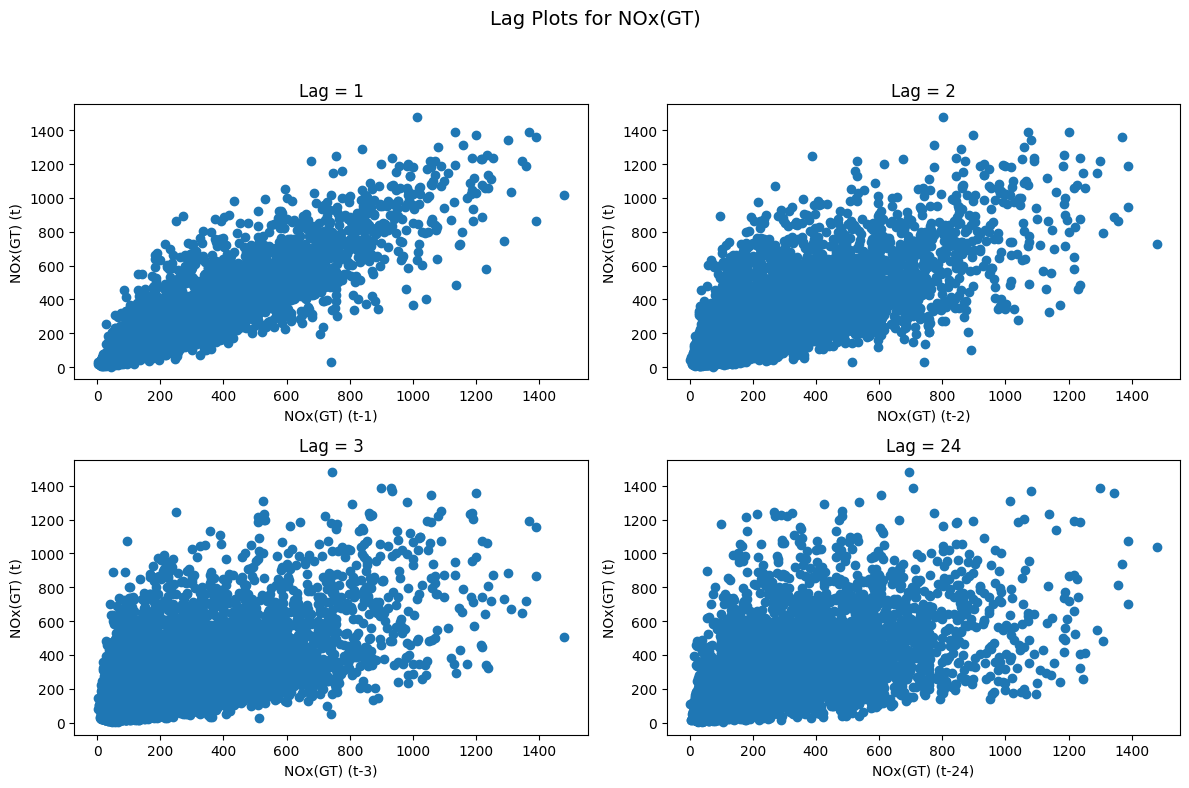

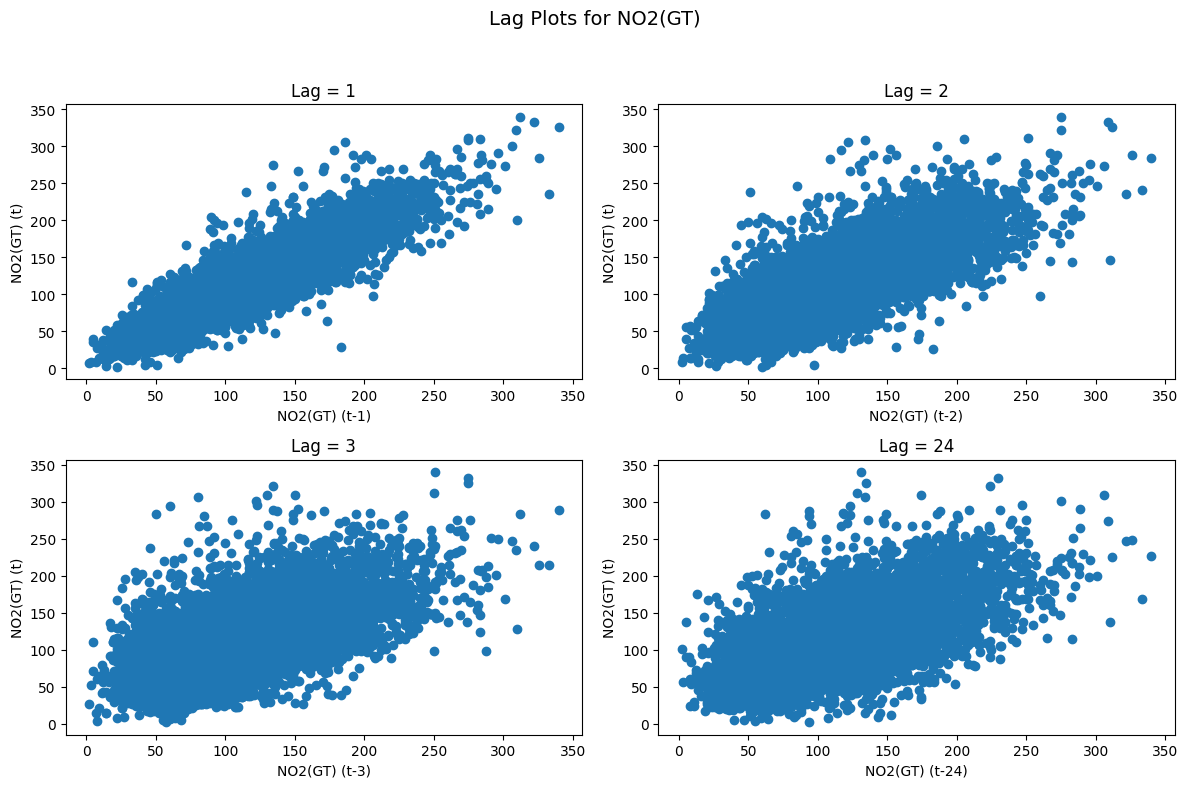

In [ ]:
# Choose which lags to inspect
lags = [1, 2, 3, 24]

# Plot lag plots for each pollutant
for var in pollutants:
    ts = df[var].dropna()

    # Skip if the time series is too short
    if len(ts) <= max(lags) + 5:
        print(f"{var}: data too short, skipped.")
        continue

    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Lag Plots for {var}", fontsize=14)

    for i, lag in enumerate(lags, 1):
        plt.subplot(2, 2, i)
        lag_plot(ts, lag=lag)
        plt.title(f"Lag = {lag}")
        plt.xlabel(f"{var} (t-{lag})")
        plt.ylabel(f"{var} (t)")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Missing values overview

NMHC(GT)         90.35
CO(GT)           18.97
NO2(GT)          18.54
NOx(GT)          18.51
PT08.S1(CO)       5.07
C6H6(GT)          5.07
PT08.S2(NMHC)     5.07
PT08.S3(NOx)      5.07
PT08.S4(NO2)      5.07
PT08.S5(O3)       5.07
T                 5.07
RH                5.07
AH                5.07
Date              1.20
Time              1.20
dtype: float64


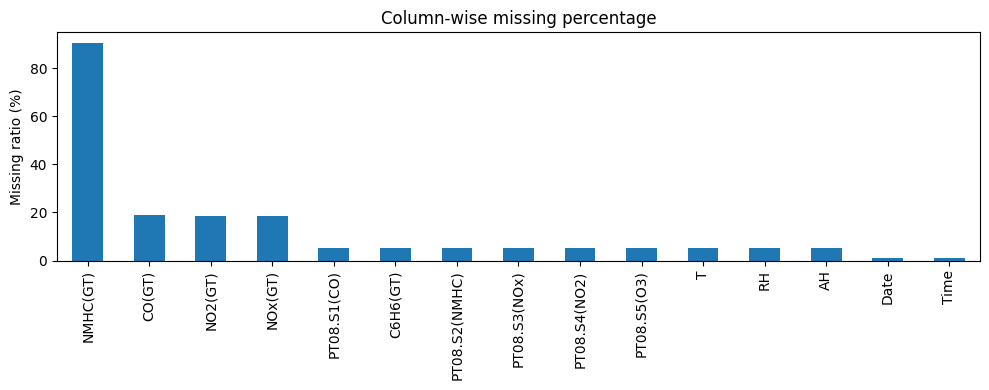

In [315]:

miss = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
print(miss)

plt.figure(figsize=(10, 4))
miss.plot(kind='bar')
plt.ylabel("Missing ratio (%)")
plt.title("Column-wise missing percentage")
plt.tight_layout()
plt.show()


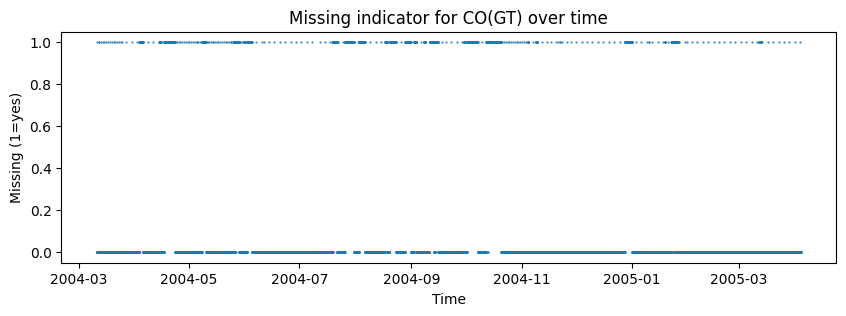

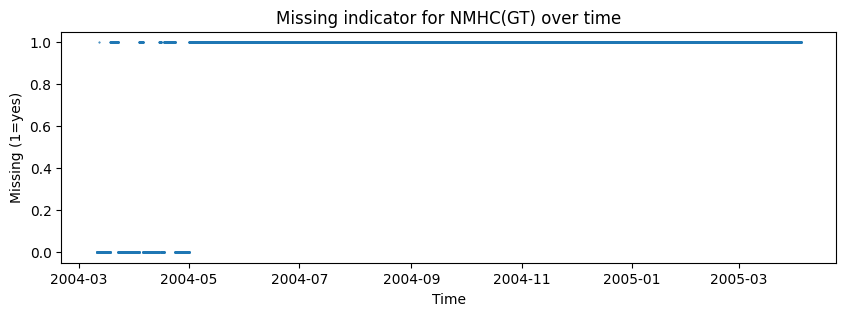

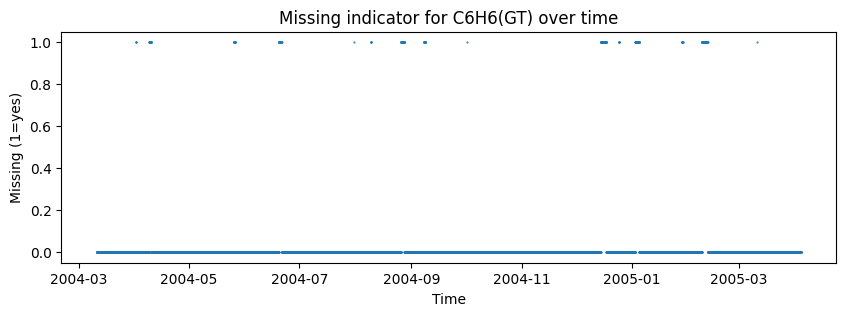

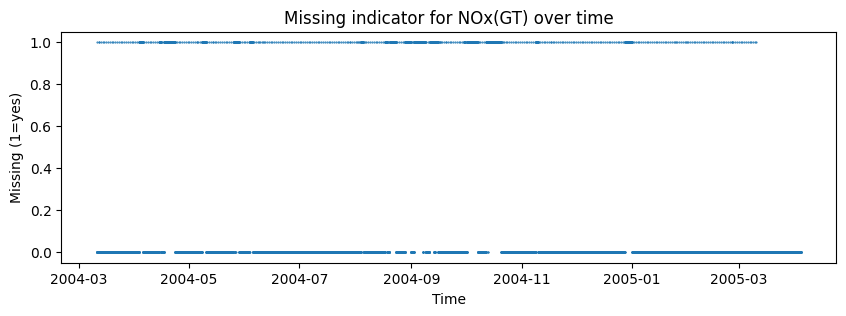

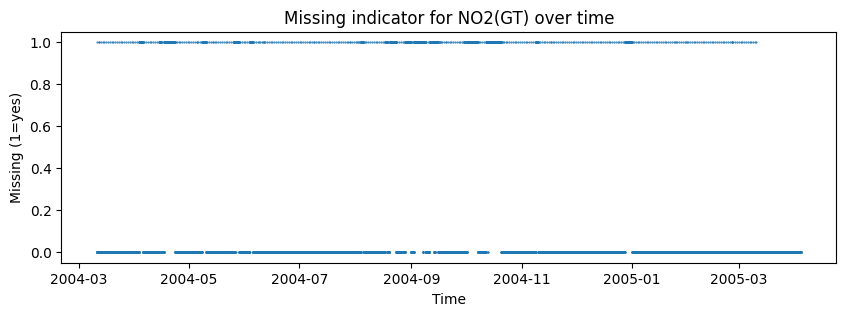

In [316]:
for col in pollutants:
    missing_indicator = df[col].isna().astype(int)

    plt.figure(figsize=(10, 3))
    plt.plot(
        missing_indicator.index,
        missing_indicator,
        linestyle="none",
        marker=".",
        markersize=1
    )
    plt.title(f"Missing indicator for {col} over time")
    plt.ylabel("Missing (1=yes)")
    plt.xlabel("Time")
    plt.show()

## Correlations among pollutants & with meteorological variables

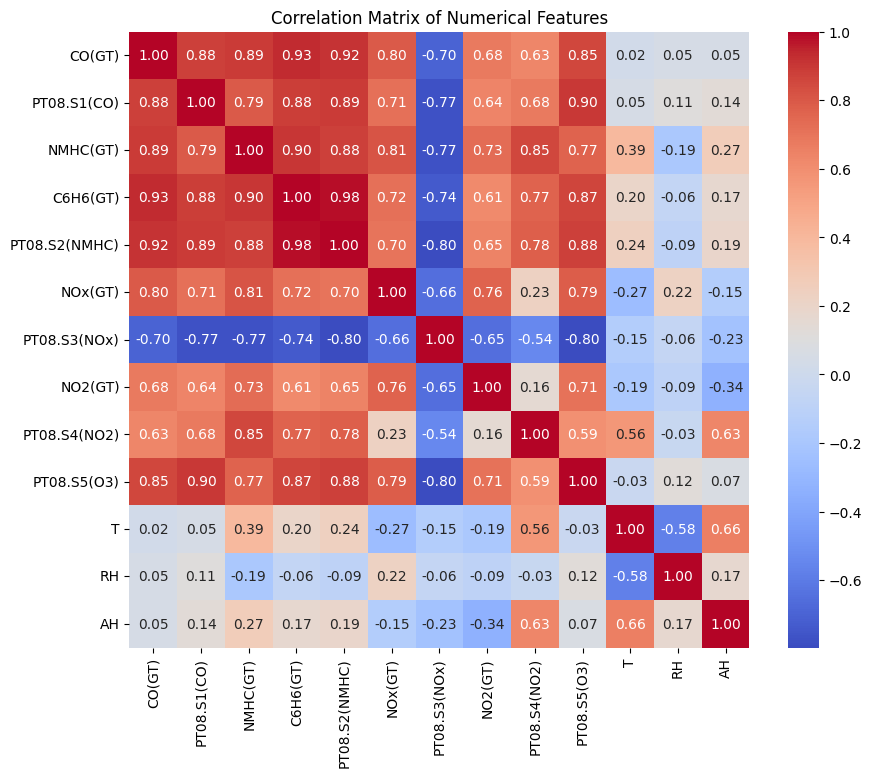

In [317]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

### Relationships between Meteorological Variables and Pollutant Concentrations (GT and PT08)

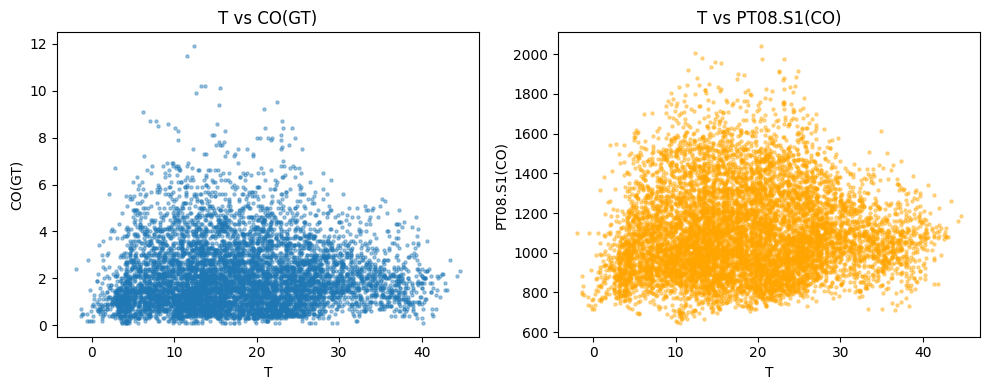

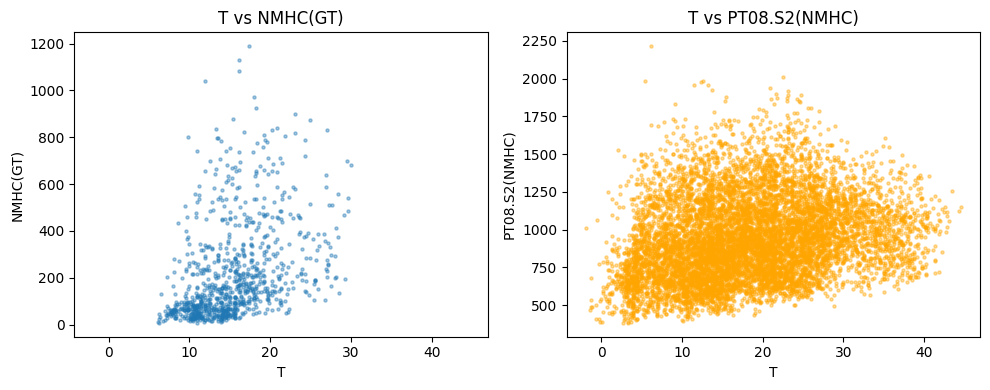

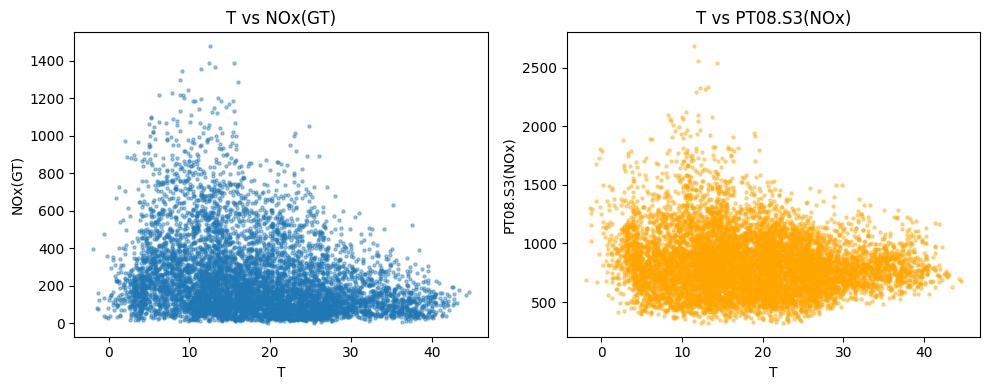

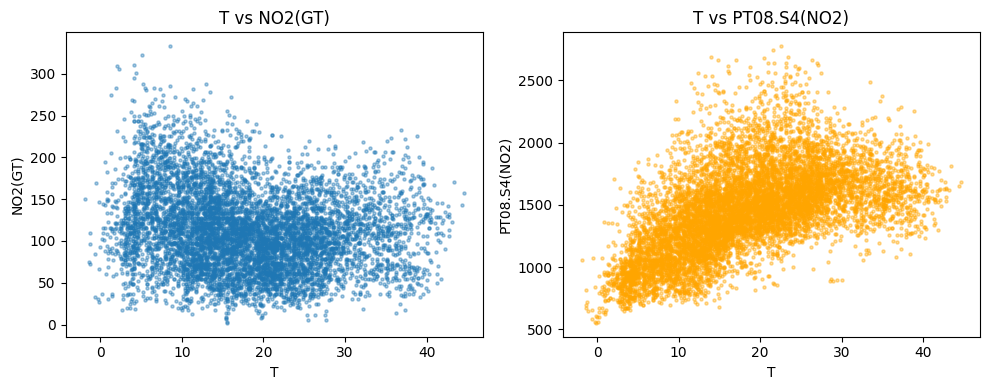

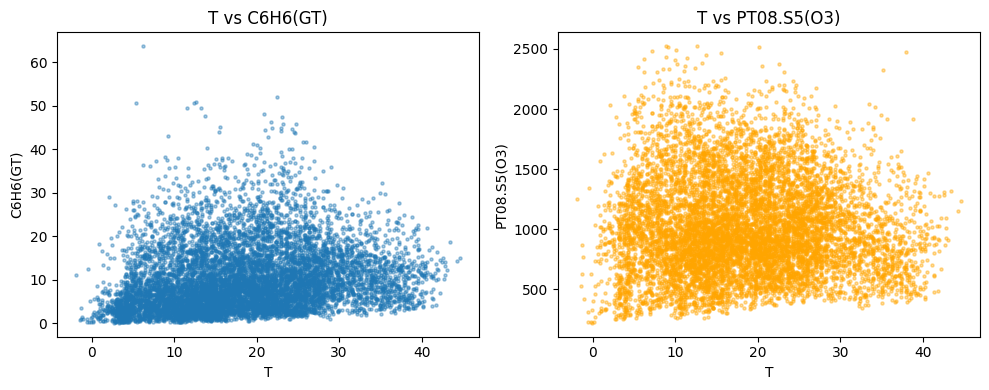

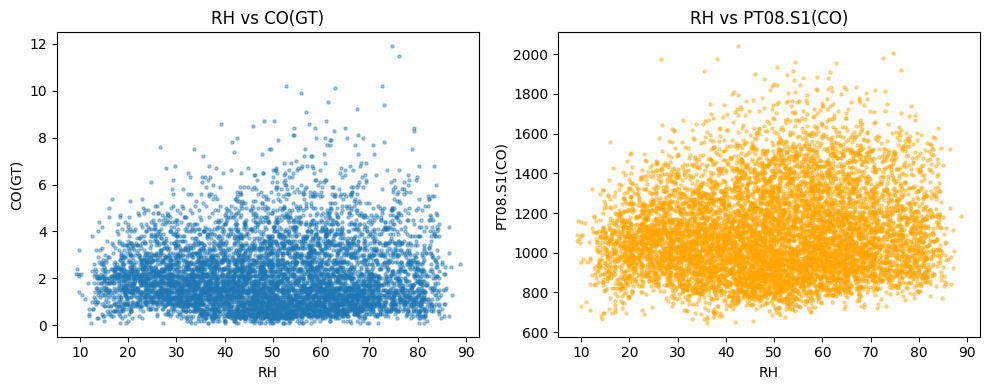

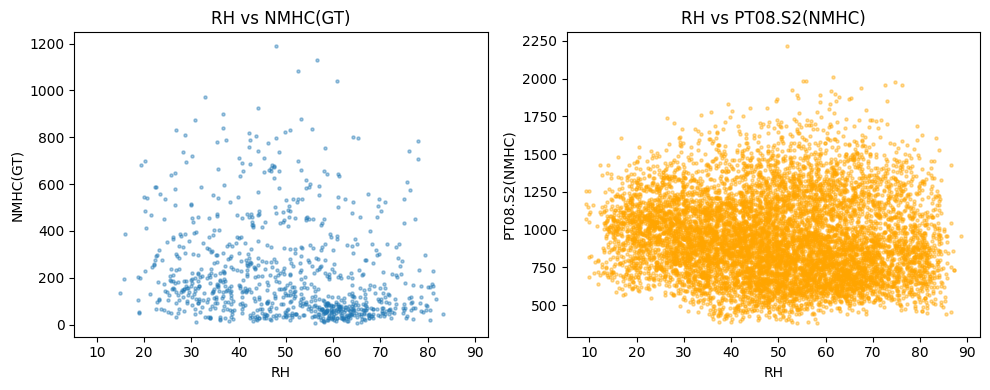

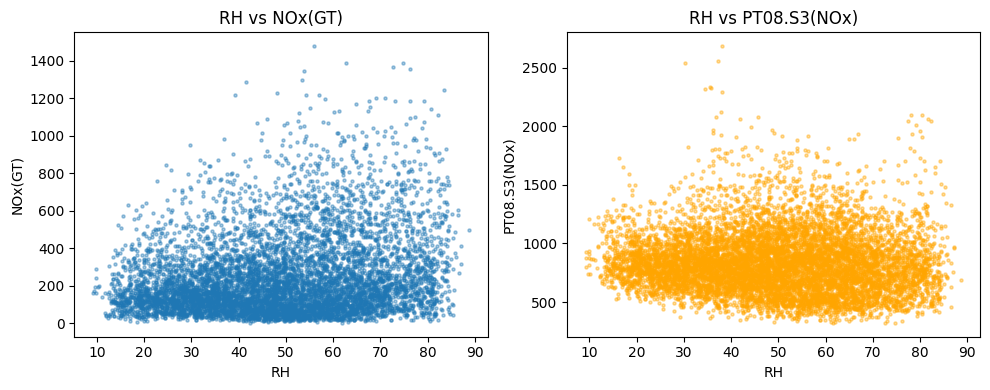

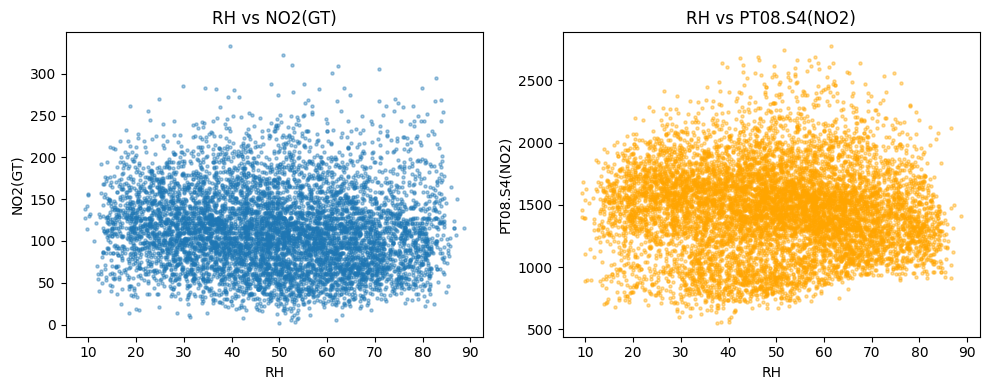

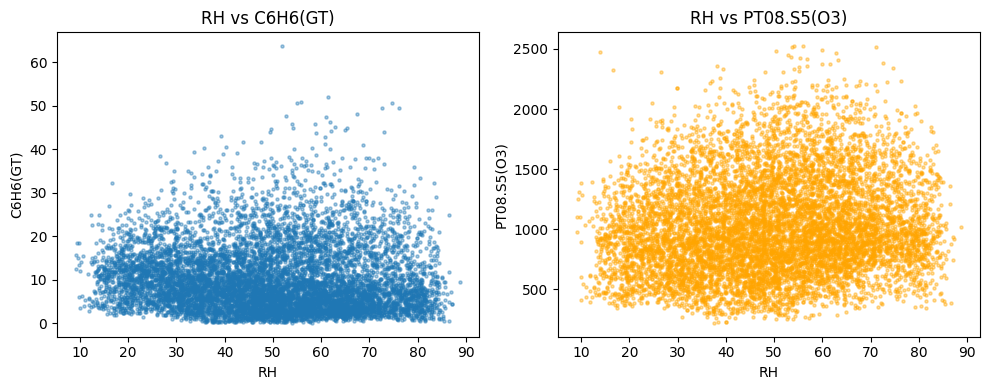

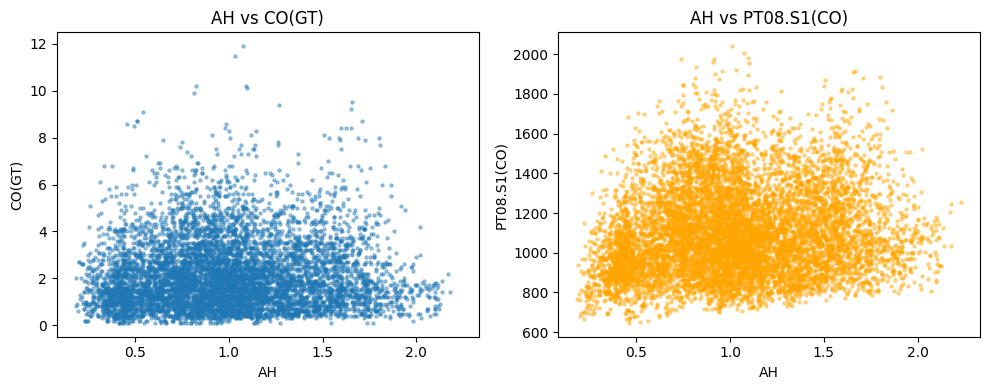

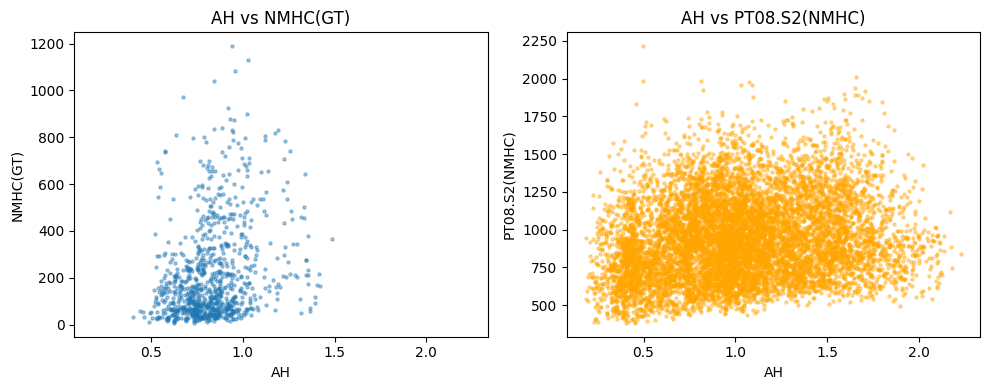

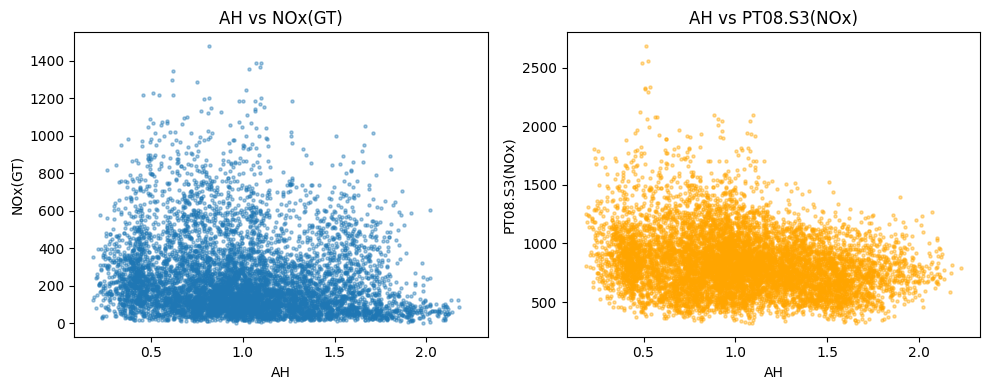

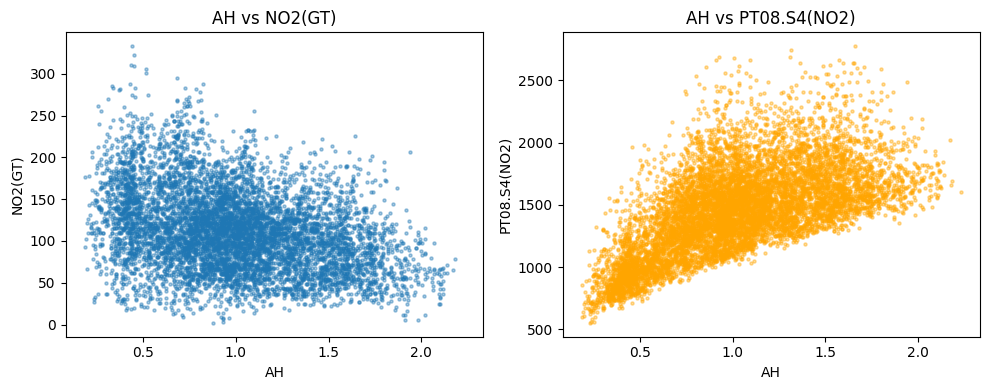

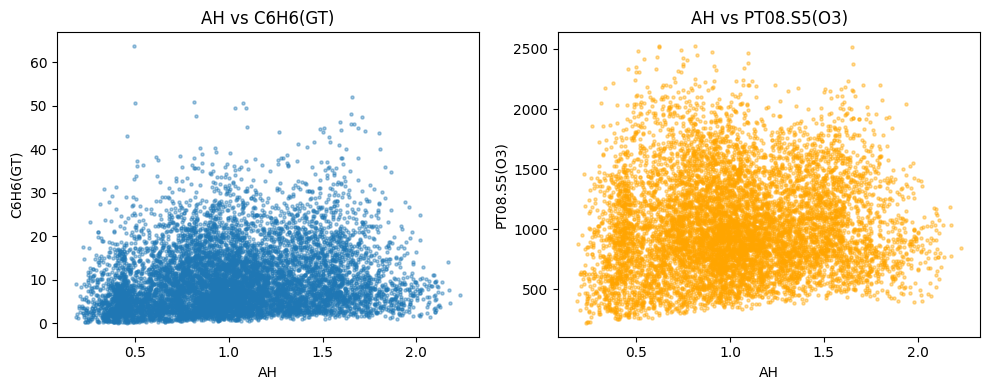

In [318]:
# Mapping: GT column ↔ sensor column
pairs = [
    ('T',  'CO(GT)',   'PT08.S1(CO)'),
    ('T',  'NMHC(GT)', 'PT08.S2(NMHC)'),
    ('T',  'NOx(GT)',  'PT08.S3(NOx)'),
    ('T',  'NO2(GT)',  'PT08.S4(NO2)'),
    ('T',  'C6H6(GT)', 'PT08.S5(O3)'),
    ('RH', 'CO(GT)',   'PT08.S1(CO)'),
    ('RH', 'NMHC(GT)', 'PT08.S2(NMHC)'),
    ('RH', 'NOx(GT)',  'PT08.S3(NOx)'),
    ('RH', 'NO2(GT)',  'PT08.S4(NO2)'),
    ('RH', 'C6H6(GT)', 'PT08.S5(O3)'),
    ('AH', 'CO(GT)',   'PT08.S1(CO)'),
    ('AH', 'NMHC(GT)', 'PT08.S2(NMHC)'),
    ('AH', 'NOx(GT)',  'PT08.S3(NOx)'),
    ('AH', 'NO2(GT)',  'PT08.S4(NO2)'),
    ('AH', 'C6H6(GT)', 'PT08.S5(O3)'),
]

for x_col, gt_col, sensor_col in pairs:
    if x_col in df.columns and gt_col in df.columns and sensor_col in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
        
        # Left: meteorological variable vs GT concentration
        axes[0].scatter(df[x_col], df[gt_col], s=5, alpha=0.4)
        axes[0].set_xlabel(x_col)
        axes[0].set_ylabel(gt_col)
        axes[0].set_title(f"{x_col} vs {gt_col}")

        # Right: meteorological variable vs PT08 sensor output
        axes[1].scatter(df[x_col], df[sensor_col], s=5, alpha=0.4, color='orange')
        axes[1].set_xlabel(x_col)
        axes[1].set_ylabel(sensor_col)
        axes[1].set_title(f"{x_col} vs {sensor_col}")

        plt.tight_layout()
        plt.show()

